In [1]:
#%matplotlib notebook
%matplotlib inline
#%config InlineBackend.figure_formats=['svg']
#%config InlineBackend.figure_formats=['pdf']

import matplotlib

matplotlib.rcParams['figure.figsize'] = (12, 9)

from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

import scipy
import scipy.stats
import math
import numpy as np
import pandas as pd

#import ipywidgets
#from ipywidgets import interact

#import sys
#sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils/")
#import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream


## Delta psi

In [2]:
CSV_FILE_PATH = "../xps/best.csv"

#WAVELET_LABEL = "WT-K-k-C1-m3-n4-s3"
WAVELET_LABEL = "WT-K-k-C1-m3-n4-s2-2-3-3"

TAILCUT_LABEL = "Tailcut-5-10"

PART = 0         # 0 for gamma, 1 for protons
BORDER = 0       # 0 all images, 1 images on border only, 2 images not on border only

FAINT_BRIGHT_BORDER = 100
LOW_CUT = 50
HIGH_CUT = 2000

full_df = pd.read_csv(CSV_FILE_PATH)

ref = full_df[full_df.Type == 'Ref']
ref = ref[ref.Part == PART]

tc = full_df[full_df.Type == TAILCUT_LABEL]
tc = tc[tc.Part == PART]

wt = full_df[full_df.Type == WAVELET_LABEL]
wt = wt[wt.Part == PART]

tc_wt = pd.merge(tc, wt, on="Id", how="outer", suffixes=('_tc', '_wt'))  #.dropna(how='any')
df = pd.merge(tc_wt, ref, on="Id", how="outer")

df["delta_tc"] = np.fmod(((df['hPsi'] - df['hPsi_tc']) * 180. / np.pi), 90.)
df["delta_wt"] = np.fmod(((df['hPsi'] - df['hPsi_wt']) * 180. / np.pi), 90.)

df.delta_tc = abs(df.delta_tc)
df.delta_wt = abs(df.delta_wt)

if BORDER == 1:
    df = df[df.border == 0]  # NOT CONTAINED
elif BORDER == 2:
    df = df[df.border > 0]   # CONTAINED

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


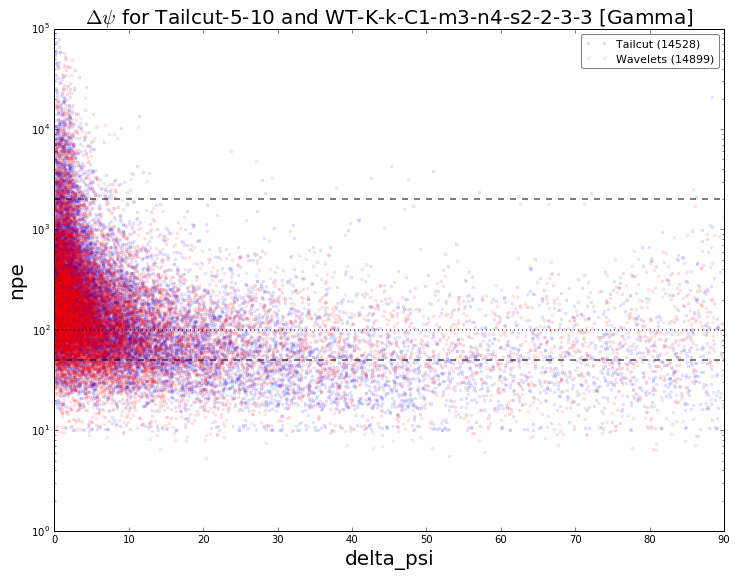

In [3]:
fig, ax = plt.subplots()

ax.plot(df['delta_tc'], df['peSum_tc'], '.b', alpha=0.1,
        label="Tailcut ({})".format(len(df[df.peSum_tc > 0])))
ax.plot(df['delta_wt'], df['peSum_wt'], '.r', alpha=0.1,
        label="Wavelets ({})".format(len(df[df.peSum_wt > 0])))

ax.axhline(y=LOW_CUT, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axhline(y=HIGH_CUT, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axhline(y=FAINT_BRIGHT_BORDER, linewidth=2, linestyle=':', color='black', alpha=0.5)

ax.set_yscale('log')

ax.set_xlabel("delta_psi", fontsize=20)
ax.set_ylabel("npe", fontsize=20)

ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

title = r"$\Delta\psi$ for {} and {} [{}]".format(TAILCUT_LABEL, WAVELET_LABEL, "Gamma" if PART == 0 else "Proton")
ax.set_title(title, fontsize=20)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


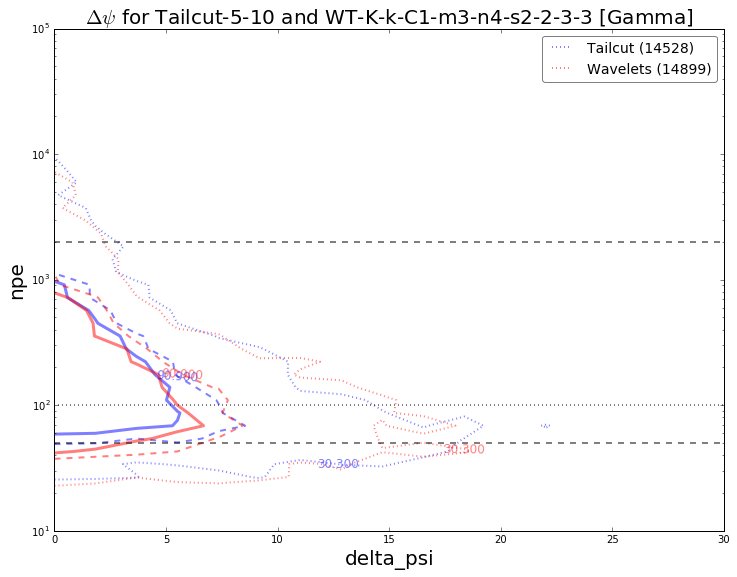

In [4]:
fig, ax = plt.subplots()

x1, y1 = df['delta_tc'], df['peSum_tc']
x2, y2 = df['delta_wt'], df['peSum_wt']

xbins = np.linspace(0, 90, 50)
ybins = np.logspace(0, 5, 50)

counts1, xedges, yedges = np.histogram2d(x1, y1, bins=(xbins, ybins))
counts2, xedges, yedges = np.histogram2d(x2, y2, bins=(xbins, ybins))

max_value = max(np.max(counts1), np.max(counts2))

#levels = np.arange(10, 60, 10)
levels = np.array([0.1*max_value, 0.3*max_value, 0.4*max_value])

cs1 = plt.contour(xedges[:-1], yedges[:-1], counts1.T, levels,
                  linewidths=(2, 2, 3), linestyles=('dotted', 'dashed', 'solid'),
                  alpha=0.5, colors='blue', label="TC")
ax.clabel(cs1, inline=False, fontsize=12)

cs2 = plt.contour(xedges[:-1], yedges[:-1], counts2.T, levels,
                  linewidths=(2, 2, 3), linestyles=('dotted', 'dashed', 'solid'),
                  alpha=0.5, colors='red', label="WT")
ax.clabel(cs2, inline=False, fontsize=12)

ax.axhline(y=LOW_CUT, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axhline(y=HIGH_CUT, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axhline(y=FAINT_BRIGHT_BORDER, linewidth=2, linestyle=':', color='black', alpha=0.5)

ax.set_xlim(0, 30)
ax.set_ylim(1e1, 1e5)

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel("delta_psi", fontsize=20)
ax.set_ylabel("npe", fontsize=20)

lines = [ cs1.collections[0], cs2.collections[0]]
labels = ["Tailcut ({})".format(len(df[df.peSum_tc > 0])), "Wavelets ({})".format(len(df[df.peSum_wt > 0]))]
ax.legend(lines, labels, prop={'size': 14}, loc='best', fancybox=True, framealpha=0.5)

title = r"$\Delta\psi$ for {} and {} [{}]".format(TAILCUT_LABEL, WAVELET_LABEL, "Gamma" if PART == 0 else "Proton")
ax.set_title(title, fontsize=20)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


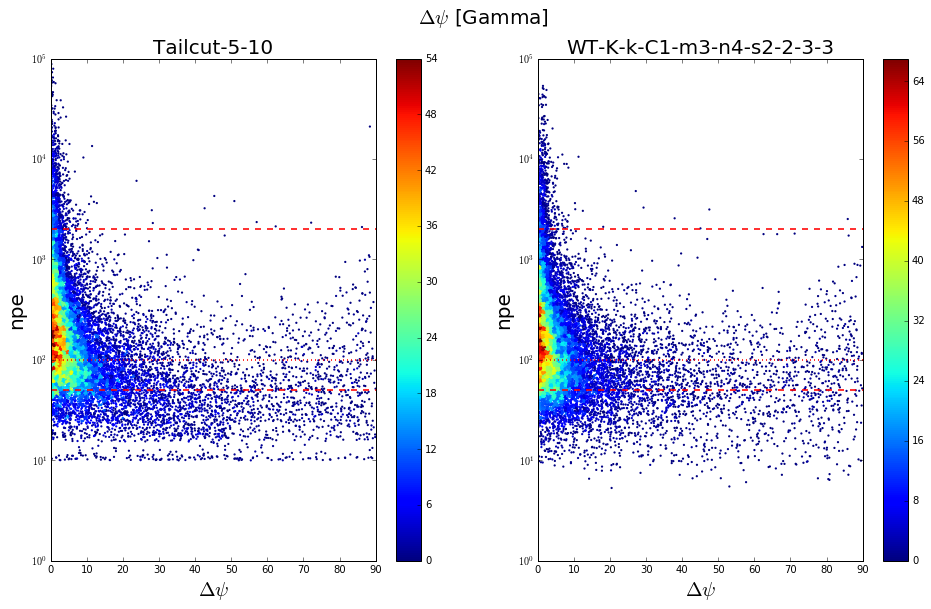

In [5]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/matplotlib/hist2d_scatter_plot_logscale_xy.py

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

x1 = df['delta_tc']
y1 = np.log10(df['peSum_tc'])
x2 = df['delta_wt']
y2 = np.log10(df['peSum_wt'])

xbins1 = np.linspace(0, 90, 90)
ybins1 = np.linspace(0, 6, 150)

xbins2 = np.linspace(0, 90, 90)
ybins2 = np.linspace(0, 6, 150)

hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=(xbins1, ybins1))
hist2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=(xbins2, ybins2))

# See http://stackoverflow.com/questions/27156381/python-creating-a-2d-histogram-from-a-numpy-matrix

xidx1 = np.clip(np.digitize(x1, xedges1), 0, hist1.shape[0]-1)
yidx1 = np.clip(np.digitize(y1, yedges1), 0, hist1.shape[1]-1)
c1 = hist1[xidx1, yidx1]

xidx2 = np.clip(np.digitize(x2, xedges2), 0, hist2.shape[0]-1)
yidx2 = np.clip(np.digitize(y2, yedges2), 0, hist2.shape[1]-1)
c2 = hist2[xidx2, yidx2]

sc1 = ax1.scatter(x1, y1,
                  c=c1,
                  s=5,
                  marker='o',
                  #cmap='gnuplot2',
                  linewidth=0,
                  alpha=1)

sc2 = ax2.scatter(x2, y2,
                  c=c2,
                  s=5,
                  marker='o',
                  #cmap='gnuplot2',
                  linewidth=0,
                  alpha=1)

fig.colorbar(sc1, ax=ax1)
fig.colorbar(sc2, ax=ax2)

# Use "10^n" instead "n" as ticks label
func_formatter = lambda x, pos: r'$10^{{{}}}$'.format(int(x))
ax1.yaxis.set_major_formatter(FuncFormatter(func_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(func_formatter))

ax1.axhline(y=np.log10(LOW_CUT), linewidth=2, linestyle='--', color='red', alpha=0.8)
ax1.axhline(y=np.log10(HIGH_CUT), linewidth=2, linestyle='--', color='red', alpha=0.8)
ax1.axhline(y=np.log10(FAINT_BRIGHT_BORDER), linewidth=2, linestyle=':', color='red', alpha=0.8)
ax2.axhline(y=np.log10(LOW_CUT), linewidth=2, linestyle='--', color='red', alpha=0.8)
ax2.axhline(y=np.log10(HIGH_CUT), linewidth=2, linestyle='--', color='red', alpha=0.8)
ax2.axhline(y=np.log10(FAINT_BRIGHT_BORDER), linewidth=2, linestyle=':', color='red', alpha=0.8)

ax1.set_xlabel(r"$\Delta\psi$", fontsize=20)
ax1.set_ylabel("npe", fontsize=20)
ax2.set_xlabel(r"$\Delta\psi$", fontsize=20)
ax2.set_ylabel("npe", fontsize=20)

#ax1.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)
#ax2.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)

ax1.set_xlim(0, 90)
ax2.set_xlim(0, 90)

ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)

ax1.set_title(TAILCUT_LABEL, fontsize=20)
ax2.set_title(WAVELET_LABEL, fontsize=20)

title = r"$\Delta\psi$ [{}]".format("Gamma" if PART == 0 else "Proton")
fig.suptitle(title, fontsize=20)

## Delta psi ratio

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


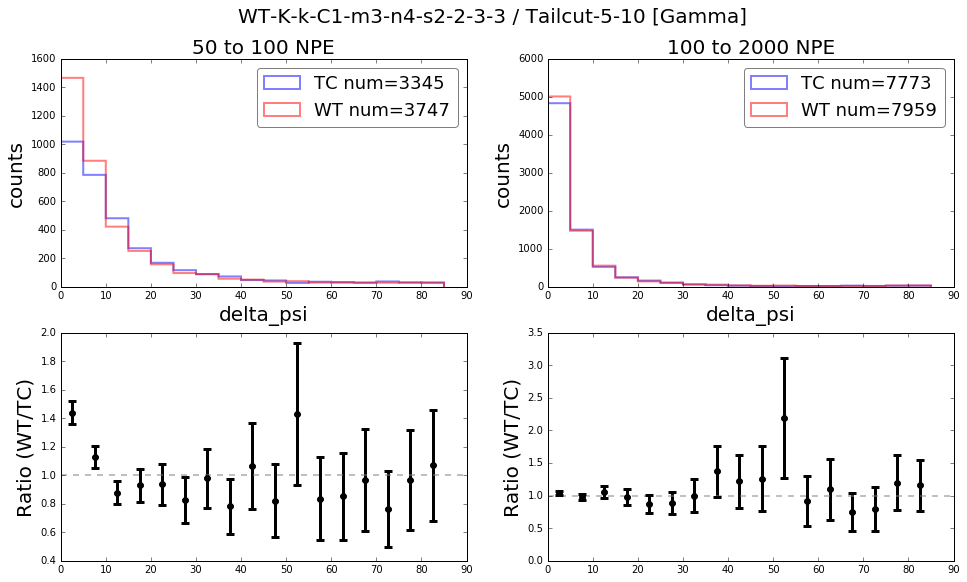

In [6]:
# Plot delta psi #####################

def plot_ratio(ax, res_tuple_tc, res_tuple_wt):
    val_of_bins_tc, bins_tc, patches_tc = res_tuple_tc
    val_of_bins_wt, bins_wt, patches_wt = res_tuple_wt
    edges_of_bins = bins_tc

    # Set ratio where val_of_bins_data is not zero
    ratio = np.divide(val_of_bins_wt,
                      val_of_bins_tc,
                      where=(val_of_bins_tc != 0))

    # Compute error on ratio (null if cannot be computed)
    # This is wrong as it's made for Gaussian distributions and here we have Poisson distribution
    error = np.divide(val_of_bins_wt * np.sqrt(val_of_bins_tc) + val_of_bins_tc * np.sqrt(val_of_bins_wt),
                       np.power(val_of_bins_tc, 2),
                       where=(val_of_bins_tc != 0))

    ax.set_ylabel('Ratio (WT/TC)', fontsize=20)
    ax.axhline(y=1, linewidth=2, linestyle='--', color='gray', alpha=0.5)

    bincenter = 0.5 * (edges_of_bins[1:] + edges_of_bins[:-1])
    ax.errorbar(bincenter, ratio, yerr=error, fmt='o', color='k', elinewidth=3, capsize=4, capthick=3, linewidth=6)
    ax.plot(bincenter, ratio, 'ok', linewidth=6)

################################

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

#BINS_START, BINS_STOP, BINS_STEP = 0., 99., 9.
#BINS_START, BINS_STOP, BINS_STEP = 0., 99., 9.

#BINS = np.arange(BINS_START, BINS_STOP, BINS_STEP)
#BINS = 30
#BINS = np.linspace(BINS_START, BINS_STOP, 30)
#BINS = [3.53056780e-03, 5.99515231e+00, 1.19867741e+01, 1.79783958e+01, 2.39700176e+01, 2.99616393e+01,
#        3.59532610e+01, 4.19448828e+01, 4.79365045e+01, 5.39281263e+01, 5.99197480e+01, 6.59113698e+01,
#        7.19029915e+01, 7.78946133e+01, 8.38862350e+01, 8.98778568e+01]
#BINS = 15                   # <- The one used for the postdoc presentation
BINS = np.arange(0, 90, 5)

################################

NPE_MIN, NPE_MAX = LOW_CUT, FAINT_BRIGHT_BORDER

df1 = df[df.peSum_tc > NPE_MIN][df.peSum_tc <= NPE_MAX]['delta_tc']
df2 = df[df.peSum_wt > NPE_MIN][df.peSum_wt <= NPE_MAX]['delta_wt']

res_tuple_tc1 = ax1.hist(df1,
                         label="TC num={}".format(len(df1)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='blue', histtype="step")

res_tuple_wt1 = ax1.hist(df2,
                         label="WT num={}".format(len(df2)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='red',  histtype="step")

ax1.set_title("{} to {} NPE".format(NPE_MIN, NPE_MAX), fontsize=20)
ax1.set_xlabel("delta_psi", fontsize=20)
ax1.set_ylabel("counts", fontsize=20)
ax1.legend(prop={'size': 18}, loc='best', fancybox=True, framealpha=0.5)

plot_ratio(ax3, res_tuple_tc1, res_tuple_wt1)

################################

NPE_MIN, NPE_MAX = FAINT_BRIGHT_BORDER, HIGH_CUT

df1 = df[df.peSum_tc > NPE_MIN][df.peSum_tc <= NPE_MAX]['delta_tc']
df2 = df[df.peSum_wt > NPE_MIN][df.peSum_wt <= NPE_MAX]['delta_wt']

res_tuple_tc2 = ax2.hist(df1,
                         label="TC num={}".format(len(df1)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='blue', histtype="step")

res_tuple_wt2 = ax2.hist(df2,
                         label="WT num={}".format(len(df2)),
                         bins=BINS,
                         linewidth=2, alpha=.5, color='red',  histtype="step")

ax2.set_title("{} to {} NPE".format(NPE_MIN, NPE_MAX), fontsize=20)
ax2.set_xlabel("delta_psi", fontsize=20)
ax2.set_ylabel("counts", fontsize=20)
ax2.legend(prop={'size': 18}, loc='best', fancybox=True, framealpha=0.5)

plot_ratio(ax4, res_tuple_tc2, res_tuple_wt2)

#ax.set_yscale('log')

suptitle_str = "{} / {} [{}]".format(WAVELET_LABEL, TAILCUT_LABEL, "Gamma" if PART == 0 else "Proton")

if BORDER == 1:
    suptitle_str += " (NOT CONTAINED)"
elif BORDER == 2:
    suptitle_str += " (CONTAINED)"
    
fig.suptitle(suptitle_str, fontsize=20)

## Delta psi from script

Rem: this is a cross check, you can ignore it...

In [7]:
#%run ./utils/plot_delta_psi.py --notebook --metric hillas2_delta_psi_norm2 xps/2017_02_23_sapcta/run_8/score_gamma_all_wavelets_mrfilter_kill.json xps/2017_02_22_sapcta/run_1/score_gamma_all_tailcut_kill.json